Import Library

In [25]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# TAHAP 1: BUSINESS UNDERSTANDING

## Proyek: Sistem Rekomendasi Cerdas Wisata Bogor (DSS Wisata Bogor)

### Latar Belakang (Business Background)

Bogor, yang terdiri dari Kota dan Kabupaten, merupakan salah satu destinasi wisata utama di Indonesia, khususnya bagi warga Jabodetabek. Wilayah ini memiliki kekayaan destinasi yang luar biasa, mencakup ratusan tempat wisata alam (curug, gunung, situ), wisata rekreasi (taman hiburan, outbound), wisata budaya (situs, museum), dan kuliner.



Namun, kekayaan pilihan ini ironisnya menciptakan sebuah masalah: "Paradox of Choice". Wisatawan, baik domestik maupun mancanegara, sering kali mengalami kebingungan (information overload) dalam menentukan destinasi yang paling sesuai dengan preferensi, lokasi, dan ekspektasi kualitas mereka.



Platform yang ada saat ini, seperti Google Maps atau portal review, berfungsi sangat baik sebagai mesin pencari (search engine) namun kurang optimal sebagai mesin rekomendasi (recommendation engine). Seorang pengguna bisa mencari "wisata alam", namun mereka tidak bisa dengan mudah mencari "wisata alam seperti Kebun Raya, yang berjarak dalam 10 km dari hotel saya di Cisarua, dan memiliki rating di atas 4.5."

Proyek ini bertujuan untuk menjembatani kesenjangan tersebut.

# TAHAP 2: DATA UNDERSTANDING (PEMAHAMAN DATA)

## Memuat Data

In [26]:
file_path = "data_wisata_bogor_final.csv"

df_raw = pd.read_csv(file_path)

print(f"\nBerhasil memuat data asli: '{file_path}'")
print(f"Jumlah total baris: {len(df_raw)}")


Berhasil memuat data asli: 'data_wisata_bogor_final.csv'
Jumlah total baris: 2842


## Eksplorasi Data Awal

### Info Struktur Data

In [27]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2842 entries, 0 to 2841
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama_tempat_wisata  2842 non-null   object 
 1   kategori            2842 non-null   object 
 2   preferensi          2842 non-null   object 
 3   kecamatan           2842 non-null   object 
 4   kabupaten_kota      2842 non-null   object 
 5   rating              2779 non-null   float64
 6   jumlah_rating       2779 non-null   float64
 7   harga_tiket         0 non-null      float64
 8   link                2842 non-null   object 
 9   latitude            2842 non-null   float64
 10  longitude           2842 non-null   float64
 11  link_gambar         2585 non-null   object 
dtypes: float64(5), object(7)
memory usage: 266.6+ KB


### Statistik Deskriptif Fitur Numerik

In [28]:
df_raw.describe()

,rating,jumlah_rating,harga_tiket,latitude,longitude
count,2779.000000,2779.00000,0.0,2842.000000,2842.000000
mean,4.495790,1492.36416,NaN,-6.568873,106.799231
std,0.347407,6139.85349,NaN,0.099911,0.140577
min,1.000000,1.00000,NaN,-6.887042,106.046521
25%,4.300000,20.00000,NaN,-6.648722,106.696630
50%,4.500000,106.00000,NaN,-6.580649,106.796937
75%,4.700000,796.00000,NaN,-6.488876,106.904573
max,5.000000,102121.00000,NaN,-6.214557,107.797893


### Contoh Data

In [29]:
df_raw.head()

,nama_tempat_wisata,kategori,preferensi,kecamatan,kabupaten_kota,rating,jumlah_rating,harga_tiket,link,latitude,longitude,link_gambar
0,Kolam renang pancar,Rekreasi,Wisata Rekreasi,Babakan Madang,Kabupaten Bogor,4.2,58.0,NaN,https://www.google.com/maps/place/Kolam+renang...,-6.574515,106.912986,https://lh3.googleusercontent.com/gps-cs-s/AG0...
1,Wisata Edukasi TK SD di Bogor,Budaya,Wisata Budaya & Edukasi,Babakan Madang,Kabupaten Bogor,4.9,1615.0,NaN,https://www.google.com/maps/place/Wisata+Eduka...,-6.575724,106.840356,https://lh3.googleusercontent.com/p/AF1QipP9Ol...
2,Curug Cibaliung Jonggol,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,4.6,749.0,NaN,https://www.google.com/maps/place/Curug+Cibali...,-6.599597,106.958568,https://lh3.googleusercontent.com/p/AF1QipOvrJ...
3,Gunung Pancar Tour Wisata Hot Spring Water,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,3.6,506.0,NaN,https://www.google.com/maps/place/Gunung+Panca...,-6.580854,106.904627,https://lh3.googleusercontent.com/gps-cs-s/AG0...
4,Wisata Bukit Domba,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,4.6,476.0,NaN,https://www.google.com/maps/place/Wisata+Bukit...,-6.624837,106.906346,https://lh3.googleusercontent.com/gps-cs-s/AG0...


## Visualisasi distribusi data

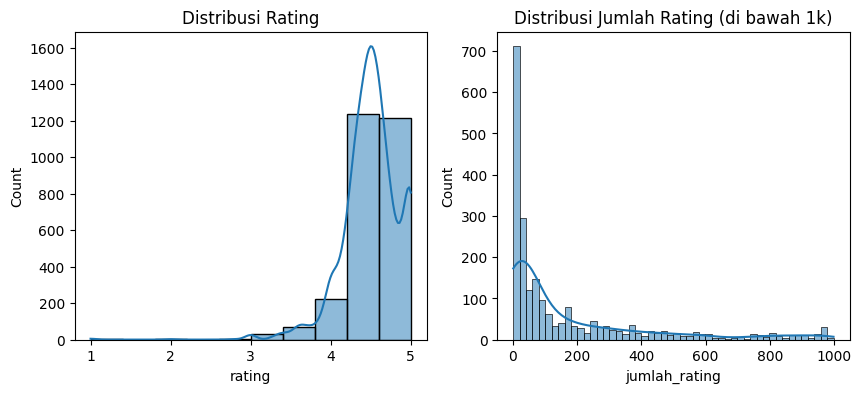

In [30]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['rating'], bins=10, kde=True)
plt.title('Distribusi Rating')

plt.subplot(1, 2, 2)
sns.histplot(df_raw[df_raw['jumlah_rating'] < 1000]['jumlah_rating'], bins=50, kde=True)
plt.title('Distribusi Jumlah Rating (di bawah 1k)')
plt.show()

## Menyimpan Data Filtered yang Lebih Lengkap (untuk keperluan tampilan aplikasi)

In [31]:
import pandas as pd

# Buat salinan dari df_filtered untuk dimodifikasi
df_complete_filtered = df_filtered.copy()

# 1. Hapus kolom 'harga_tiket' jika ada
if 'harga_tiket' in df_complete_filtered.columns:
    df_complete_filtered = df_complete_filtered.drop(columns=['harga_tiket'])
    print("Kolom 'harga_tiket' berhasil dihapus.")
else:
    print("Kolom 'harga_tiket' tidak ditemukan di DataFrame.")

# 2. Tentukan URL gambar placeholder Unsplash
unsplash_placeholder_url = "https://images.unsplash.com/photo-1506744038136-46273834288b?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# 3. Isi data kosong di 'link_gambar' dengan URL placeholder
df_complete_filtered['link_gambar'].fillna(unsplash_placeholder_url, inplace=True)
print("Data kosong di 'link_gambar' telah diisi.")

# Tampilkan informasi singkat DataFrame yang baru
print("\nInfo DataFrame yang akan disimpan:")
df_complete_filtered.info()

# Simpan DataFrame yang telah dimodifikasi ke file CSV baru
output_filename_complete = "df_wisata_bogor_final_prepared.csv"
df_complete_filtered.to_csv(output_filename_complete, index=False, encoding='utf-8-sig')
print(f"\nDataFrame yang lebih lengkap berhasil disimpan ke '{output_filename_complete}'")
print("Anda dapat mengunduh file ini untuk digunakan di aplikasi Anda.")

Kolom 'harga_tiket' berhasil dihapus.
Data kosong di 'link_gambar' telah diisi.

Info DataFrame yang akan disimpan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama_tempat_wisata  1346 non-null   object 
 1   kategori            1346 non-null   object 
 2   preferensi          1346 non-null   object 
 3   kecamatan           1346 non-null   object 
 4   kabupaten_kota      1346 non-null   object 
 5   rating              1346 non-null   float64
 6   jumlah_rating       1346 non-null   float64
 7   link                1346 non-null   object 
 8   latitude            1346 non-null   float64
 9   longitude           1346 non-null   float64
 10  link_gambar         1346 non-null   object 
dtypes: float64(4), object(7)
memory usage: 115.8+ KB

DataFrame yang lebih lengkap berhasil disimpan ke 'df_wisata_bogor_final_prepared.csv

/tmp/ipython-input-424237764.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_complete_filtered['link_gambar'].fillna(unsplash_placeholder_url, inplace=True)


# TAHAP 3: DATA PREPARATION (PERSIAPAN DATA)

## Pembersihan dan Filtering

In [32]:
df = df_raw.dropna(subset=['rating', 'jumlah_rating', 'latitude', 'longitude', 'kategori', 'preferensi', 'kecamatan'])
print(f"Baris setelah menghapus NaN (data kosong): {len(df)}")

Baris setelah menghapus NaN (data kosong): 2779


### Menerapkan filter kualitas (sesuai Business Understanding)

In [33]:
# Kita hanya ingin merekomendasikan tempat yang "layak"
RATING_THRESHOLD = 4.0  # Minimal rating 4.5
REVIEWS_THRESHOLD = 100 # Minimal 100 ulasan

df_filtered = df[(df['rating'] >= RATING_THRESHOLD) & (df['jumlah_rating'] >= REVIEWS_THRESHOLD)].copy()
print(f"Baris setelah filter kualitas (Rating >= {RATING_THRESHOLD} & Ulasan >= {REVIEWS_THRESHOLD}): {len(df_filtered)}")

Baris setelah filter kualitas (Rating >= 4.0 & Ulasan >= 100): 1346


In [34]:
# Reset index agar konsisten
df_filtered.reset_index(drop=True, inplace=True)

In [35]:
# Membuat dataframe terpisah untuk 'lookup' (pencarian)
# Ini berisi info yang tidak kita pakai untuk training, tapi penting untuk hasil akhir
df_lookup = df_filtered[['nama_tempat_wisata', 'link', 'latitude', 'longitude', 'rating', 'jumlah_rating', 'kategori']]

## Rekayasa Fitur (Feature Engineering)

In [36]:
# Mendefinisikan fitur untuk autoencoder (sesuai Data Understanding)
# Kita ingin "kesamaan" berdasarkan: rating, jumlah ulasan, kategori, preferensi, dan kecamatan
numerical_features = ['rating', 'jumlah_rating']
categorical_features = ['kategori', 'preferensi', 'kecamatan']

# Membuat transformer
# 1. Normalisasi fitur numerik (MinMaxScaler): Scaling 0-1
# 2. Encoding fitur kategorikal (OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Abaikan kolom lain
)

# Terapkan preprocessor
preprocessed_data = preprocessor.fit_transform(df_filtered)
print(f"Data berhasil diproses. Dimensi data input untuk model: {preprocessed_data.shape}")

Data berhasil diproses. Dimensi data input untuk model: (1346, 56)


# TAHAP 4: MODELING (PEMODELAN)

## Arsitektur Autoencoder

In [37]:
# Tujuannya: Mengkompresi fitur" menjadi 'embedding' (representasi laten)
# Ini adalah unsupervised learning untuk klasterisasi/pencarian kesamaan
input_dim = preprocessed_data.shape[1]
bottleneck_dim = 8  # Dimensi laten (embedding)

# Input layer
input_layer = Input(shape=(input_dim,), name="Input_Layer")
# Encoder (Mengecil)
encoder = Dense(64, activation='relu', name="Encoder_1")(input_layer)
encoder = Dense(32, activation='relu', name="Encoder_2")(encoder)
bottleneck = Dense(bottleneck_dim, activation='relu', name="Bottleneck_Layer")(encoder)
# Decoder (Membesar kembali)
decoder = Dense(32, activation='relu', name="Decoder_1")(bottleneck)
decoder = Dense(64, activation='relu', name="Decoder_2")(decoder)
output_layer = Dense(input_dim, activation='sigmoid', name="Output_Layer")(decoder) # Sigmoid karena input 0-1

# Gabungkan jadi Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(), loss='mse') # Loss = MSE (sesuai rencana)

autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_1 (Dense)               │ (None, 64)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_2 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck_Layer (Dense)        │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_1 (Dense)               │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_2 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 56)             │         3,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,032 (47.00 KB)

 Trainable params: 12,032 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

## Pelatihan Model

In [38]:
preprocessed_data_dense = preprocessed_data.toarray().astype(np.float32)
history = autoencoder.fit(preprocessed_data_dense, preprocessed_data_dense,
                          epochs=50,
                          batch_size=16,
                          shuffle=True, # Changed to True for better training performance
                          verbose=1)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1620
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 16/50
85/85 ━

## Menghasilkan Embeddings (Representasi Laten)

In [39]:
# Kita buat model 'encoder' terpisah untuk mendapatkan output bottleneck
encoder_model = Model(inputs=input_layer, outputs=bottleneck, name="Encoder")

In [40]:
# Prediksi untuk mendapatkan embedding dari semua data
place_embeddings = encoder_model.predict(preprocessed_data.toarray().astype(np.float32))
print(f"Berhasil membuat embedding untuk {place_embeddings.shape[0]} tempat. Dimensi: {place_embeddings.shape[1]}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Berhasil membuat embedding untuk 1346 tempat. Dimensi: 8


## Menghitung Matriks Kesamaan (Similarity Matrix)

In [41]:
# Menghitung kesamaan antar semua tempat berdasarkan embedding-nya
similarity_matrix = cosine_similarity(place_embeddings)
print(f"Matriks kesamaan berhasil dibuat. Ukuran: {similarity_matrix.shape}")

Matriks kesamaan berhasil dibuat. Ukuran: (1346, 1346)


# TAHAP 5: EVALUATION (EVALUASI)

## Evaluasi Kuantitatif (Metrik Model)

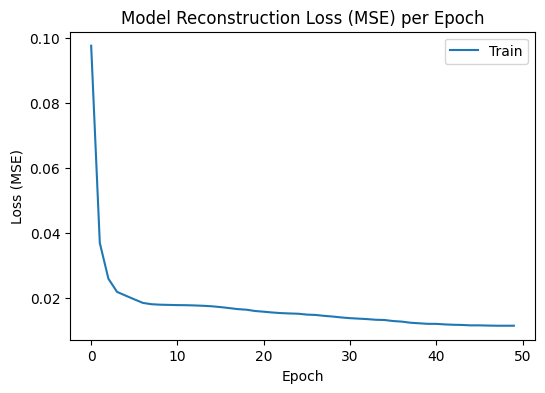

Final Reconstruction Loss (MSE): 0.011485


In [42]:
# Metrik utama untuk autoencoder adalah 'Reconstruction Loss' (MSE)
# plot loss selama training
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Model Reconstruction Loss (MSE) per Epoch')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()
print(f"Final Reconstruction Loss (MSE): {history.history['loss'][-1]:.6f}")

## Fungsi Pembantu (Geospasial)

In [43]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# TAHAP 6: DEPLOYMENT (PENYEBARAN)

Catatan: 'Deployment' dalam konteks ini adalah membuat fungsi siap pakai.

Fungsi ini dapat dipanggil di aplikasi web (cth: Streamlit atau Flask).

## Membuat Fungsi Rekomendasi Final

In [44]:
def get_recommendations_hybrid(input_place_name, user_lat, user_lon, radius_km=10, top_n=5):
    """
    Memberikan rekomendasi hybrid (3 Lapis):
    1. Mencari tempat yang 'mirip' (Content-Based Deep Learning)
    2. Memfilter yang 'dekat' (Geospatial Filter)
    3. Mengurutkan dari yang 'terbaik' (Quality Sort)
    """

    # 1. Cari index dari tempat yang diinput
    try:
        # Gunakan df_lookup yang index-nya sudah di-reset
        place_index = df_lookup[df_lookup['nama_tempat_wisata'] == input_place_name].index[0]
    except IndexError:
        print(f"Error: Tempat '{input_place_name}' tidak ditemukan di database.")
        return pd.DataFrame()

    # 2. Dapatkan skor kesamaan (dari Autoencoder)
    similarity_scores = list(enumerate(similarity_matrix[place_index]))

    # 3. Buat DataFrame dari skor
    df_similar = pd.DataFrame(similarity_scores, columns=['index', 'similarity'])

    # Gabungkan dengan info dari df_lookup (pastikan index cocok)
    df_similar = df_similar.join(df_lookup)

    # 4. Hitung jarak (Geospatial Filter)
    df_similar['distance_km'] = df_similar.apply(
        lambda row: haversine(user_lat, user_lon, row['latitude'], row['longitude']),
        axis=1
    )

    # 5. Terapkan Filter
    # Hapus tempat input itu sendiri dari rekomendasi
    df_final_recs = df_similar[df_similar['index'] != place_index]

    # Filter berdasarkan radius
    df_final_recs = df_final_recs[df_final_recs['distance_km'] <= radius_km]

    # 6. Urutkan berdasarkan Kualitas & Kesamaan (Quality Sort)
    # Ini adalah logika inti:
    # 1. Utamakan kesamaan (similarity)
    # 2. Jika mirip, utamakan rating tertinggi
    # 3. Jika rating sama, utamakan ulasan terbanyak
    df_final_recs = df_final_recs.sort_values(
        by=['similarity', 'rating', 'jumlah_rating'],
        ascending=[False, False, False]
    )

    return df_final_recs.head(top_n)

## Contoh Penggunaan (Kembali ke Evaluasi Kualitatif)

In [45]:
print(" 🚀 PENGUJIAN FUNGSI DEPLOYMENT 🚀 ")

 🚀 PENGUJIAN FUNGSI DEPLOYMENT 🚀 


### CONTOH 1: WISATA BUDAYA

In [46]:
print("\n" + "="*30)
print(" 🚀 CONTOH 1: WISATA BUDAYA 🚀 ")
print("="*30)

input_place = "Taman Budaya Sentul City"
user_location = (-6.58, 106.88) # Lokasi user (misal: dekat Taman Budaya)
search_radius = 20 # Mencari dalam radius 20 km

print(f"\nUser berada di: {user_location}")
# Ambil kategori dari df_lookup
kategori_input_1 = df_lookup.loc[df_lookup['nama_tempat_wisata'] == input_place, 'kategori'].values
if len(kategori_input_1) > 0:
    print(f"User baru saja mengunjungi: {input_place} (Kategori: {kategori_input_1[0]})")
else:
    print(f"User baru saja mengunjungi: {input_place} (Kategori: Tidak Ditemukan)")

print(f"Mencari rekomendasi serupa dalam radius {search_radius} km...")

# Dapatkan rekomendasi
recommendations = get_recommendations_hybrid(input_place, user_location[0], user_location[1], radius_km=search_radius)

if recommendations.empty:
    print("\nMaaf, tidak ditemukan rekomendasi yang mirip dan berdekatan.")
else:
    print("\n--- HASIL REKOMENDASI (BUDAYA) ---")
    for i, row in recommendations.iterrows():
        print(f"  Nama: {row['nama_tempat_wisata']} (Kategori: {row['kategori']})")
        print(f"  Rating: {row['rating']} ({row['jumlah_rating']} ulasan)")
        print(f"  Jarak: {row['distance_km']:.2f} km")
        print(f"  Kesamaan: {row['similarity']:.3f}")
        print(f"  Link: {row['link']}\n")


 🚀 CONTOH 1: WISATA BUDAYA 🚀 

User berada di: (-6.58, 106.88)
User baru saja mengunjungi: Taman Budaya Sentul City (Kategori: Budaya)
Mencari rekomendasi serupa dalam radius 20 km...

--- HASIL REKOMENDASI (BUDAYA) ---
  Nama: Taman Budaya Sentul City (Kategori: Budaya)
  Rating: 4.5 (22782.0 ulasan)
  Jarak: 0.63 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/Taman+Budaya+Sentul+City/data=!4m7!3m6!1s0x2de423a153dbb7df:0xaac1aacd454d4019!8m2!3d-6.5843706!4d106.8835962!16s%2Fg%2F1hm2399fm!19sChIJ37fbU6Ej5C0RGUBNRc2qwao?authuser=0&hl=id&rclk=1

  Nama: Taman Budaya Sentul City (Kategori: Budaya)
  Rating: 4.5 (22782.0 ulasan)
  Jarak: 0.63 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/Taman+Budaya+Sentul+City/data=!4m7!3m6!1s0x2de423a153dbb7df:0xaac1aacd454d4019!8m2!3d-6.5843706!4d106.8835962!16s%2Fg%2F1hm2399fm!19sChIJ37fbU6Ej5C0RGUBNRc2qwao?authuser=0&hl=id&rclk=1

  Nama: Museum & Monumen PETA (Kategori: Budaya)
  Rating: 4.6 (1697.0 ulasan)
  Jarak:

### CONTOH 2: WISATA ALAM

In [47]:
print("\n" + "="*30)
print(" 🚀 CONTOH 2: WISATA ALAM 🚀 ")
print("="*30)

input_place_2 = "Curug Cilember"
user_location_2 = (-6.68, 106.94) # Lokasi user (di Cisarua)
search_radius_2 = 15

print(f"User berada di: {user_location_2}")
kategori_input_2 = df_lookup.loc[df_lookup['nama_tempat_wisata'] == input_place_2, 'kategori'].values
if len(kategori_input_2) > 0:
    print(f"User baru saja mengunjungi: {input_place_2} (Kategori: {kategori_input_2[0]})")
else:
    print(f"User baru saja mengunjungi: {input_place_2} (Kategori: Tidak Ditemukan)")

print(f"Mencari rekomendasi serupa dalam radius {search_radius_2} km...")

recommendations_2 = get_recommendations_hybrid(input_place_2, user_location_2[0], user_location_2[1], radius_km=search_radius_2)

if recommendations_2.empty:
    print("\nMaaf, tidak ditemukan rekomendasi yang mirip dan berdekatan.")
else:
    print("\n--- HASIL REKOMENDASI (ALAM) ---")
    for i, row in recommendations_2.iterrows():
        print(f"  Nama: {row['nama_tempat_wisata']} (Kategori: {row['kategori']})")
        print(f"  Rating: {row['rating']} ({row['jumlah_rating']} ulasan)")
        print(f"  Jarak: {row['distance_km']:.2f} km")
        print(f"  Kesamaan: {row['similarity']:.3f}")
        print(f"  Link: {row['link']}\n")


 🚀 CONTOH 2: WISATA ALAM 🚀 
User berada di: (-6.68, 106.94)
User baru saja mengunjungi: Curug Cilember (Kategori: Alam)
Mencari rekomendasi serupa dalam radius 15 km...

--- HASIL REKOMENDASI (ALAM) ---
  Nama: KEBUN JATI PANCAWATI (Kategori: Alam)
  Rating: 4.5 (1248.0 ulasan)
  Jarak: 8.01 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/KEBUN+JATI+PANCAWATI/data=!4m7!3m6!1s0x2e69cb2ec5739ce3:0x2e9b8df614bb59d4!8m2!3d-6.7248679!4d106.8832063!16s%2Fg%2F11g0vy8k9w!19sChIJ45xzxS7LaS4R1Fm7FPaNmy4?authuser=0&hl=id&rclk=1

  Nama: Puncak Halimun Camp Bogor (Kategori: Alam)
  Rating: 4.5 (951.0 ulasan)
  Jarak: 8.15 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/Puncak+Halimun+Camp+Bogor/data=!4m7!3m6!1s0x2e69cb336030c3d9:0x11ea53e1963a48fd!8m2!3d-6.7345438!4d106.8907165!16s%2Fg%2F11pbzv2ym2!19sChIJ2cMwYDPLaS4R_Ug6luFT6hE?authuser=0&hl=id&rclk=1

  Nama: Taman Kecubung (Kategori: Alam)
  Rating: 4.5 (190.0 ulasan)
  Jarak: 5.24 km
  Kesamaan: 1.000
  Link: htt

# Fase 1: Modifikasi Notebook Colab (Menyimpan "Otak")

In [48]:
import joblib
import pickle

print("\n" + "="*60)
print("FASE 1: MENYIMPAN ARTIFAK MODEL UNTUK DEPLOYMENT")

# 1. Menyimpan DataFrame 'lookup' yang sudah bersih dan ter-filter
# Ini adalah data utama yang akan dibaca oleh Streamlit
df_lookup_filename = "df_lookup_wisata.csv"
df_lookup.to_csv(df_lookup_filename, index=False, encoding='utf-8-sig')
print(f"Berhasil menyimpan: {df_lookup_filename}")

# 2. Menyimpan Matriks Kesamaan (Similarity Matrix)
# Ini adalah "OTAK" dari model Deep Learning kita.
# Streamlit akan memuat file ini, BUKAN melatih ulang model.
matrix_filename = "similarity_matrix.npy"
np.save(matrix_filename, similarity_matrix)
print(f"Berhasil menyimpan: {matrix_filename}")

# 3. (Opsional tapi direkomendasikan) Menyimpan Preprocessor
# Untuk berjaga-jaga jika kita perlu memproses input baru
preprocessor_filename = "preprocessor.pkl"
with open(preprocessor_filename, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"Berhasil menyimpan: {preprocessor_filename}")

print("\nAnda sekarang siap untuk Fase 2.")
print("Unduh file-file berikut dari Colab:")
print(f"1. {df_lookup_filename}")
print(f"2. {matrix_filename}")
print(f"3. {preprocessor_filename} (Opsional)")
print(f"4. {output_filename_complete}") # Menambahkan file df_complete_filtered
print("5. data_wisata_bogor_final.csv (File asli Anda)")


FASE 1: MENYIMPAN ARTIFAK MODEL UNTUK DEPLOYMENT
Berhasil menyimpan: df_lookup_wisata.csv
Berhasil menyimpan: similarity_matrix.npy
Berhasil menyimpan: preprocessor.pkl

Anda sekarang siap untuk Fase 2.
Unduh file-file berikut dari Colab:
1. df_lookup_wisata.csv
2. similarity_matrix.npy
3. preprocessor.pkl (Opsional)
4. data_wisata_bogor_lengkap.csv (File asli Anda)
